In [1]:
#Librerias
import tensorflow as tf      #libreria para trabajar con redes neuronales
import keras as kr
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np           #libreria matematica
import matplotlib.pyplot as plt     #libreria matematica
import pandas as pd          #libreria leer archivo
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from math import sqrt
from keras.preprocessing.sequence import TimeseriesGenerator
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
#importar datos guardados de archivos .csv 
def parser(x):
	return pd.datetime.strptime(x, "%d/%m/%Y")
datasett = pd.read_csv("IPC_VAR_MENSUAL.csv",sep=";",date_parser=parser, index_col=0, squeeze=False,decimal=",",
                      names=["Fechas","IPC General","IPC SAE","IPC sin volatiles"],parse_dates=True,skiprows=3,encoding="latin-1")

datasett.describe()
dataset = datasett["IPC General"]

C:\Users\Abraham\AppData\Local\Temp/ipykernel_24464/2388035418.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  return pd.datetime.strptime(x, "%d/%m/%Y")


In [3]:
#Funcion para mostrar el dataset en graficp
def plot_dataset(dataset):
    dataset.plot(figsize=(25,10))
    plt.ylabel("IPC")
    plt.xlabel("Fecha")
    plt.show()

In [3]:
#Funcion ingresa el año que se  quiera graficar
def plot_year(year,dataset):
    fig , ax = plt.subplots(figsize = (20,10))
    data_for_year = dataset[year]
    plt.plot(data_for_year["IPC General"])
    plt.title(year,y=0,loc="left")
    plt.show()
    fig.tight_layout()

In [4]:
#Muestra la descompocicion de la serie temporal, muestra la tendencia, estacionaridad y el ruido
def plot_sensonal(dataset):
    result = seasonal_decompose(dataset)
    result.plot()
    plt.show()

In [5]:
#Trasforma los datos de una a datos supervisado ,X entrada , Y salida
def data_supervisado(data,n_input):
  x , y = [] , []
  for i in range(n_input,len(data)-n_input):
    x.append(data[i-n_input+1:i+1])
    y.append(data[i+1:i+n_input+1])
  x = np.array(x)
  y = np.array(y)
  return x,y

In [6]:
#Prepara los datos para el manejo en redes neuronales, separa los datos de entrenamiento y prueba, y escala los datos entre 1 y -1
def prepare_data(data,n_input,n_test):
  data = data.values
  data = data.reshape(len(data), 1)
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaled_data = scaler.fit_transform(data)
  data_train , data_test  = scaled_data[:-n_test] , scaled_data[-n_test-1:] 
  x_train,y_train = data_supervisado(data_train,n_input)
  x_test,y_test = data_supervisado(data_test,n_input)
  return scaler,x_train,y_train,x_test,y_test

In [7]:
#Crea y entrenamiento de la red neuronal LSTM 
def fit_lstm(X,y,X_test,y_test, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
    
    verbose=1
    model = kr.Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mse', optimizer='adam')
    """history = model.fit(X, y, validation_data=(X_test,y_test), epochs= nb_epoch, batch_size=n_batch, verbose=verbose, shuffle=False)
    model = kr.Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), 
                    stateful=True))
    model.add(Dense(y.shape[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')"""
    losses = []
    val_losses = []
    min_val_loss = (99999,999999)
    for i in range(nb_epoch):
        print("epoch = %d",i)
        history = model.fit(X, y, validation_data=(X_test,y_test), epochs=1, batch_size=n_batch, verbose=verbose, shuffle=False)
        losses.append(history.history['loss'])
        val_losses.append(history.history['val_loss'][0])
        if val_losses[-1] < min_val_loss[0]:
            min_val_loss = (val_losses[-1], i)
        model.reset_states()
    print('best val_loss and epoch:',min_val_loss)
    plt.title('loss')
    plt.plot(losses,label="Train")
    plt.plot(val_losses, color='red',label="validation")
    plt.show()
    return model , losses, val_losses

##Pruebas


In [8]:
#Funcion de prueba 
def run():
    # configure
    n_lag = 1
    n_seq = 6           #La cantidad de salida
    n_test = int(len(dataset)*0.2)       #Numero de datos de test
    n_epochs = 1000
    n_batch = 1         
    n_neurons = 1
    n_input =  6
    scaler , x_train , y_train , x_test , y_test = prepare_data(dataset , n_input , n_test)
    # reshape input to be 3D [samples, timesteps, features]
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    x_trains = x_train.reshape(x_train.shape[0],x_train.shape[1])
    inv_xtrain = scaler.inverse_transform(x_trains)
    y_train = y_train.reshape(y_train.shape[0],y_train.shape[1]) 
    inv_ytrain = scaler.inverse_transform(y_train)
    x_tests = x_test.reshape(x_test.shape[0],x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],y_test.shape[1]) 
    inv_xtest = scaler.inverse_transform(x_tests)
    inv_ytest = scaler.inverse_transform(y_test)
    # Plot prueba
    multi_step_plot(inv_xtest[len(inv_xtest)-1],inv_ytest[len(inv_xtest)-1],np.array([0]))
    #Entrenamineto dela red LSTM
    model , history , val_loss= fit_lstm(x_train,y_train,x_test,y_test, n_lag, n_seq, n_batch, n_epochs, n_neurons)
    return model

(888, 6, 1) (888, 6, 1) (214, 6, 1) (214, 6, 1)


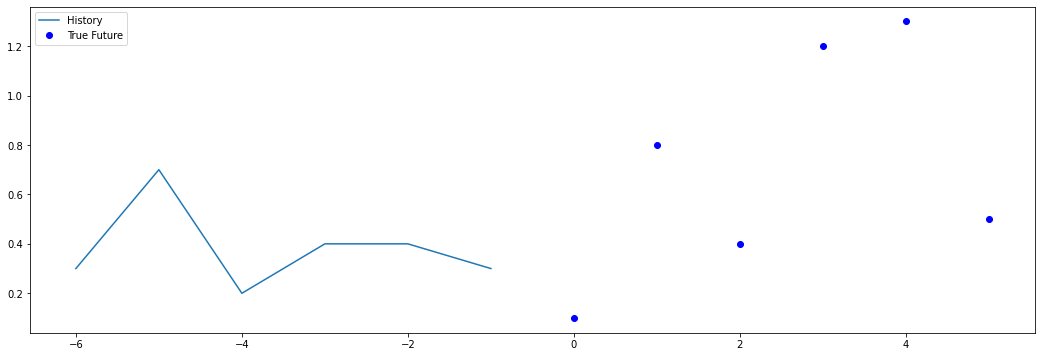

epoch = %d 0
888/888 [==============================] - 5s 4ms/step - loss: 0.1209 - val_loss: 0.0081
epoch = %d 1
888/888 [==============================] - 2s 3ms/step - loss: 0.0074 - val_loss: 2.3043e-04
epoch = %d 2
888/888 [==============================] - 3s 3ms/step - loss: 0.0063 - val_loss: 1.1272e-04
epoch = %d 3
888/888 [==============================] - 3s 3ms/step - loss: 0.0062 - val_loss: 7.6262e-05
epoch = %d 4
888/888 [==============================] - 3s 3ms/step - loss: 0.0062 - val_loss: 6.4584e-05
epoch = %d 5
888/888 [==============================] - 3s 3ms/step - loss: 0.0062 - val_loss: 6.1355e-05
epoch = %d 6
888/888 [==============================] - 3s 3ms/step - loss: 0.0061 - val_loss: 6.0360e-05
epoch = %d 7
888/888 [==============================] - 3s 3ms/step - loss: 0.0061 - val_loss: 5.9989e-05
epoch = %d 8
888/888 [==============================] - 3s 3ms/step - loss: 0.0061 - val_loss: 5.9818e-05
epoch = %d 9
888/888 [============================

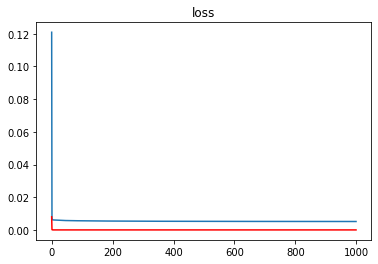

In [14]:
model = run()

In [16]:
model.save('modelo_directo.h5')

In [18]:
import keras
model = keras.models.load_model('modelo_directo.h5')

In [19]:
from pandas import DataFrame
# experiment
repeats = 5
results = DataFrame()
# vary training epochs
epochs = [1,2,5,10,25]
for e in epochs:
	results[str(e)] = evaluate(repeats, dataset,e)

(888, 6, 1) (888, 6, 1) (214, 6, 1) (214, 6, 1)
1
1000
epoch = %d 0
201/888 [=====>........................] - ETA: 1s - loss: 0.5289

KeyboardInterrupt: 

In [20]:
#Muestra los datos que seran de prueba y entrenamiento, para este caso se 80/20, 80% entrenamiento y 20% prueba
def plot_dataset_train(dataset,n_test):
    plt.figure(figsize=(30,10))
    plt.title('Datos de entrenamiento y validacion')
    plt.ylabel('IPC General')
    plt.xlabel('Fecha')
    plt.plot( dataset[:-n_test], color = 'blue',label = 'train')
    plt.plot(dataset[-n_test-1:],color = 'red',label = 'test')
    plt.show()

In [21]:
#Muestra grafico con las predicciones, ingresa una serie que se quiere predecir y muestra los resultados
def create_time_steps(length):
    return list(range(-length, 0))
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)
    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out), true_future, 'bo',
    label='True Future')
    if prediction.any == False:
        plt.plot(np.arange(num_out), prediction, 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [22]:
#Funcion para la evaluacion del modelo con diferentes hiperparametro
def evaluate(ciclos,dataset,n_neurons):
    datasett = dataset.values
    #configure
    # configure
    n_lag = 1
    n_seq = 6           #La cantidad de salida
    n_test = int(len(dataset)*0.2)       #Numero de datos de test
    n_batch = 1         
    n_epochs = 1000
    n_input =  6
    #preparation data
    scaler , x_train , y_train , x_test , y_test = prepare_data(dataset , n_input , n_test)
    # reshape input to be 3D [samples, timesteps, features]
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
    x_trains = x_train.reshape(x_train.shape[0],x_train.shape[1])
    inv_xtrain = scaler.inverse_transform(x_trains)
    y_train = y_train.reshape(y_train.shape[0],y_train.shape[1]) 
    inv_ytrain = scaler.inverse_transform(y_train)
    x_tests = x_test.reshape(x_test.shape[0],x_test.shape[1])
    y_test = y_test.reshape(y_test.shape[0],y_test.shape[1]) 
    inv_xtest = scaler.inverse_transform(x_tests)
    inv_ytest = scaler.inverse_transform(y_test)
    #plot forecast test
    #show_plot([inv_xtest[len(inv_xtest)-2],inv_ytest[len(inv_xtest)-2]],0,'datos de prueba')
    #plt.show
    history_loss = []
    error_score = list()
    y_test_INV = y_test.reshape(y_test.shape[0],y_test.shape[1])
    y_test_INV = scaler.inverse_transform(y_test_INV)
    print(n_neurons)
    for r in range(ciclos):
        print(n_epochs)
        model , history , val_loss= fit_lstm(x_train,y_train,x_test,y_test, 
                                            n_lag, n_seq, n_batch, n_epochs, n_neurons)
        ytest_pred = model.predict(x_test,1)
        prediction = list()
        ytest_pred = scaler.inverse_transform(ytest_pred)
        rmse_ind, rmse = evaluate_model_rmse(y_test_INV,ytest_pred)
        print('%d) Test RMSE: %.3f' % (r+1, rmse))
        error_score.append(rmse)
    losses = []
    val_losses = []
    return error_score

In [23]:
#Evalua los datos de prueba con los datos predichos
def evaluate_model_rmse(y_true , y_pred):
    score = []
    for i in range(y_true.shape[1]):
        mse = mean_squared_error(y_true[:,i] , y_pred[:,i])
        rmse = sqrt(mse)
        score.append(rmse)
    total_score = 0
    for yy in range(y_true.shape[0]):
        for xx in range(y_true.shape[1]):
            total_score = total_score + (y_true[yy,xx]-y_pred[yy,xx])**2
    total_score = sqrt(total_score / (y_true.shape[0]*y_pred.shape[1]))
    return score,total_score


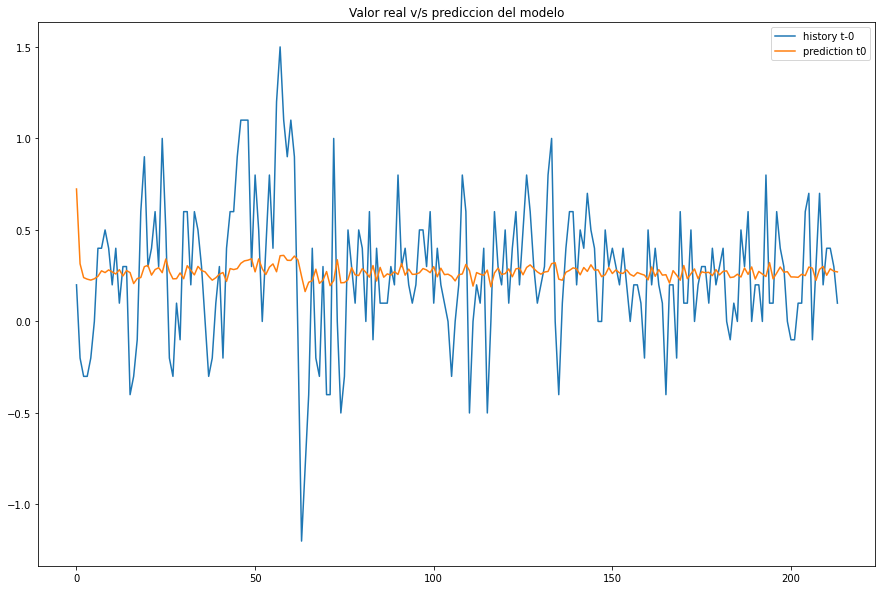

In [24]:
n_input = 6
n_test = int(len(dataset)*0.2)
scaler , x_train , y_train , x_test , y_test = prepare_data(dataset , n_input , n_test)
ytest_pred = model.predict(x_test,1)
y_test = y_test.reshape(y_test.shape[0],y_test.shape[1])
y_test = scaler.inverse_transform(y_test)
ytest_pred = scaler.inverse_transform(ytest_pred)
for i in range(1):
    plt.figure(figsize=(15,10))
    plt.plot(y_test[:,i],label = "history t-" +str(i))
    plt.plot(ytest_pred[:,i] ,label = "prediction t" + str(i))
    plt.title("Valor real v/s prediccion del modelo")
    plt.legend()
    plt.show()

In [25]:
evaluate_model_rmse(y_test,ytest_pred)

([0.3659450346871285,
  0.3811611514043856,
  0.3801312327494089,
  0.3864736045291901,
  0.3897990793280806,
  0.38860647554054994],
 0.38210371801787807)

In [28]:
def forecast_plot(history,true_value ,prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction)
    plt.plot(num_in, history, label='History')
    plt.plot(np.arange(num_out), true_value, 'green',
             label='true value')
    plt.plot(np.arange(num_out), prediction, 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [29]:
#Hace la prediccion de los valores futuro.
def make_forecast(dataset, n_input):
    x_data = dataset[-n_input::]
    x_data = x_data.values
    x_data = x_data.reshape(1,x_data.shape[0])
    x_datas = scaler.fit_transform(x_data)
    y_forecast = model.predict(x_datas,1)
    y_forecast = scaler.inverse_transform(y_forecast)
    x_data = x_data.reshape(x_data.shape[1])
    y_forecast = y_forecast.reshape(y_forecast.shape[1])
    forecast_plot(x_data,y_forecast)
    print(y_forecast)
    return y_forecast

(1, 6)
(1, 6)


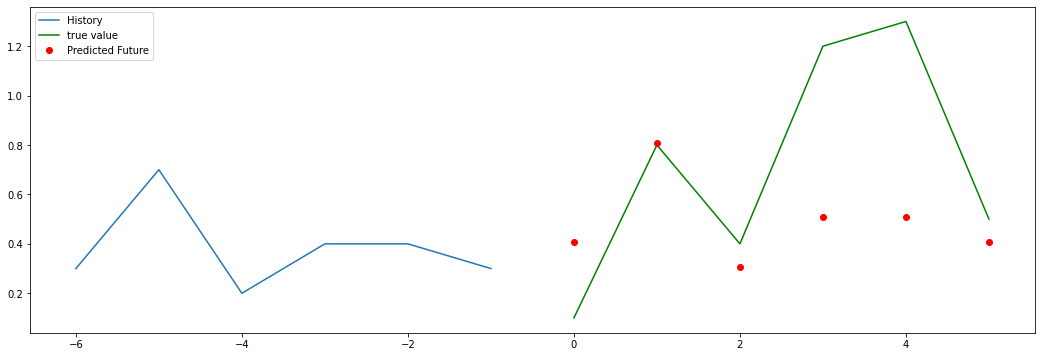

In [32]:

xas = dataset[-12:-6:]
xas = xas.values
y_true = dataset[-6::]
y_true = y_true.values
xas = xas.reshape(1,xas.shape[0])
y_true = y_true.reshape(1,y_true.shape[0])
x_sc = scaler.fit_transform(xas)
x_sc = x_sc.reshape(1,x_sc.shape[1],1)
yas = model.predict(x_sc,1)
print(yas.shape)
yas = scaler.inverse_transform(yas)
forecast_plot(xas[0],y_true[0],yas[0])

In [ ]:
"""import csv
import json

with open('dataset.json','w') as archivo:
    archivo.write("")
    archivo.close()
datasett.to_json("dataset.json", orient = "records", date_format = "epoch", double_precision = 10, force_ascii = True, date_unit = "ms", default_handler = None)
print(datasett)""""